In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import datetime
import pickle
import pyresample
from global_land_mask import globe

# Read and reformat data from FROST
The data was downloaded from FROST using get_weather_station.py and get_metadata.py

In [3]:
files = os.listdir('./stations')
files.remove('meta_data.pkl') #not a station

In [15]:
stations = []
for id_ in files:
    stations.append(xr.open_dataset("./stations/"+id_))
metadata = pd.read_pickle(r"./stations/meta_data.pkl")

In [19]:
# string datatype was lost in export, this loop fixes these strings. 
for s_i in range(len(stations)):
    stations[s_i]['id'] = stations[s_i]['id'].astype(str)
    stations[s_i]['name'] = stations[s_i]['name'].astype(str)
    stations[s_i]['shortname'] = stations[s_i]['shortname'].astype(str)
    stations[s_i]['latitude'] = float(stations[s_i]['latitude'])
    stations[s_i]['longitude'] = float(stations[s_i]['longitude'])
    stations[s_i]['resolution'] = stations[s_i]['resolution'].astype(str)
    stations[s_i] = stations[s_i].sel(time=slice('2018-08-08T08:00:00', '2018-08-08T15:00:00'))

# Map over norway and weather stations

In [23]:
# get grid from radar image
a_file = open("/home/erlend/radar.pkl", "rb")
output = pickle.load(a_file)
x_grid = output.pop('lon')
y_grid = output.pop('lat')

In [24]:
map_norway = np.zeros(x_grid.shape)
for i in range(map_norway.shape[0]):
    for j in range(map_norway.shape[1]):
        map_norway[i, j] = globe.is_land(y_grid[i, j], x_grid[i, j])       

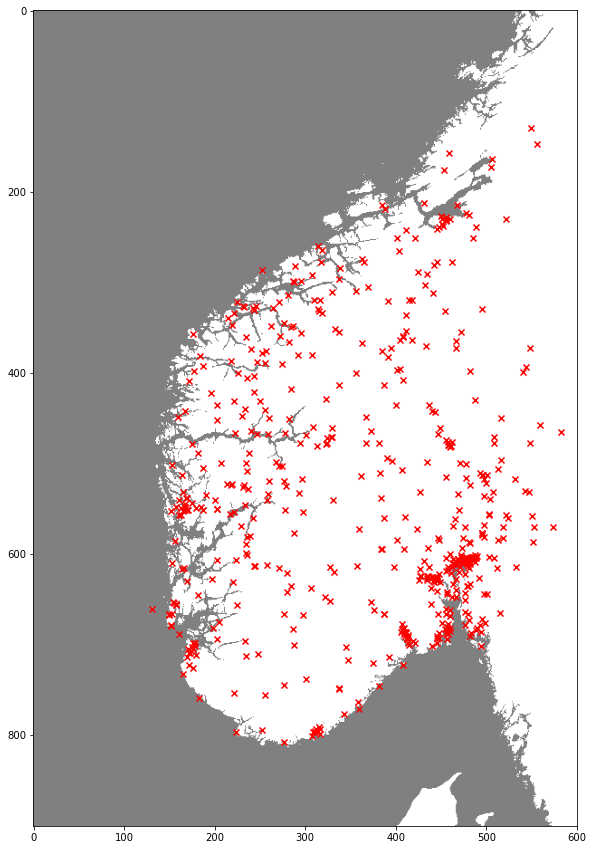

In [25]:
# locate nearest latitude-longitude value on grid from weather radar data: 
df = pd.DataFrame(metadata).T # coordinates

grid = pyresample.geometry.GridDefinition(lats=y_grid, lons=x_grid)
# My 
my_lons = df['lon'].to_numpy().astype(float)
my_lats = df['lat'].to_numpy().astype(float)
swath = pyresample.geometry.SwathDefinition(lons=my_lons, lats=my_lats)

# Determine nearest (w.r.t. great circle distance) neighbour in the grid.
_, _, index_array, distance_array = pyresample.kd_tree.get_neighbour_info(
    source_geo_def=grid, target_geo_def=swath, radius_of_influence=50000,
    neighbours=1)

# get_neighbour_info() returns indices in the flattened lat/lon grid. Compute
# the 2D grid indices:
index_array_2d = np.unravel_index(index_array, grid.shape)
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(map_norway, alpha=0.5, cmap='gray')
ax.scatter(index_array_2d[1], index_array_2d[0], marker='x', c='r')

# Frequency of hourly precipitation 

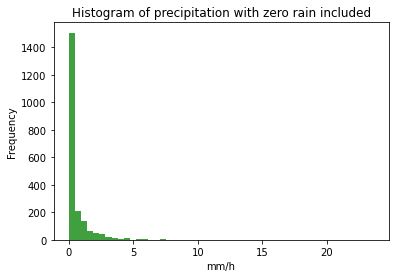

max precipitation:  23.6


In [26]:
x = []
for stat in stations:
    for obs in stat['PT1H']:
        x.append(float(obs))

n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('mm/h')
plt.ylabel('Frequency')
plt.title('Histogram of precipitation with zero rain included')
plt.show()
print("max precipitation: ", max(x))

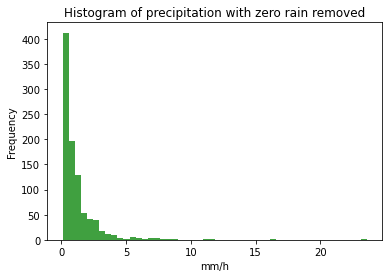

max precipitation:  23.6


In [27]:
x = []
for stat in stations:
    for obs in stat['PT1H']:
        if float(obs) != 0.0:
            x.append(float(obs))

n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('mm/h')
plt.ylabel('Frequency')
plt.title('Histogram of precipitation with zero rain removed')
plt.show()
print("max precipitation: ", max(x))

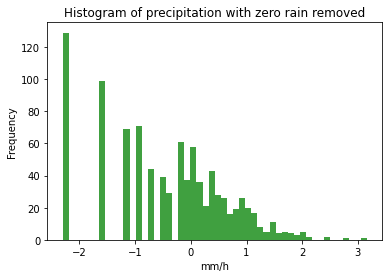

max precipitation:  3.1612467120315646


In [28]:
x = []
for stat in stations:
    for obs in stat['PT1H']:
        if float(obs) != 0.0:
            x.append(float(obs))

x = np.array(x)
x = np.log(x)
n, bins, patches = plt.hist(x, 50, density=False, facecolor='g', alpha=0.75)
plt.xlabel('mm/h')
plt.ylabel('Frequency')
plt.title('Histogram of precipitation with zero rain removed')
#plt.xlim(0, 5)
#plt.ylim(0, 3)
plt.show()
print("max precipitation: ", max(x))

### Kriging interpolation

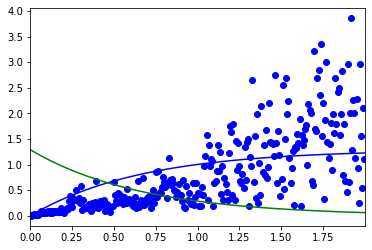

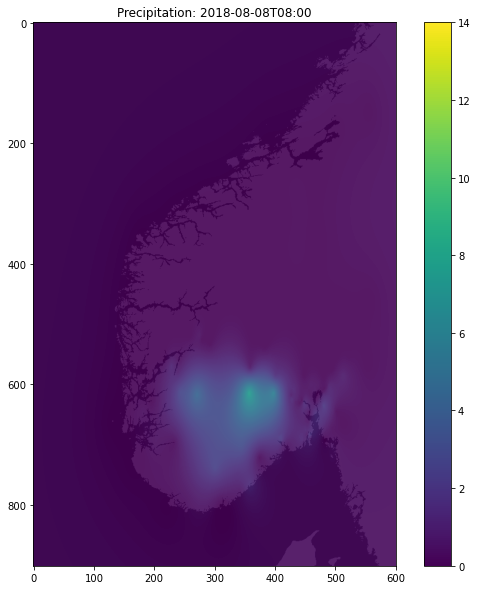

Min precipitation value:  [[0.35368056 0.3536765  0.35367234 ... 0.32382619 0.3244122  0.32499258]
 [0.35367848 0.35367436 0.35367016 ... 0.32347484 0.32406929 0.32465797]
 [0.35367637 0.3536722  0.35366794 ... 0.32311996 0.32372294 0.32432005]
 ...
 [0.34525061 0.34509144 0.3449296  ... 0.34676605 0.34681806 0.34687054]
 [0.3453069  0.34514899 0.34498846 ... 0.34685219 0.34690348 0.34695523]
 [0.34536299 0.34520636 0.34504711 ... 0.34693724 0.34698786 0.34703889]]


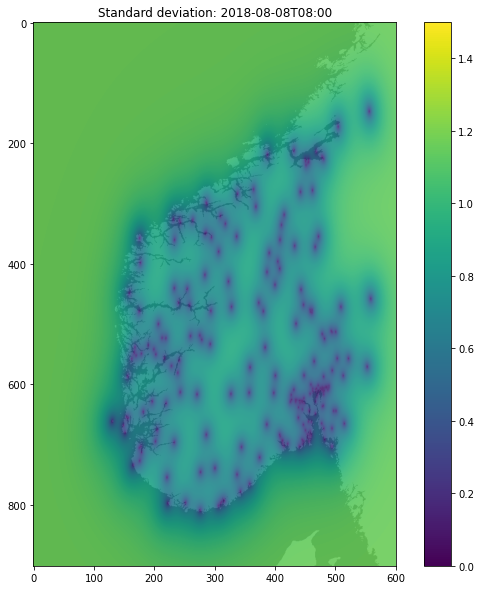

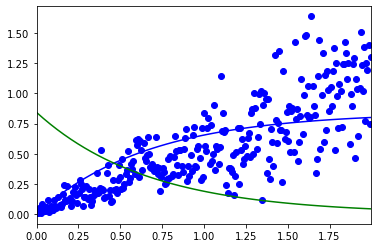

KeyboardInterrupt: 

In [30]:
from geostat import OrdinaryKriging # my own module

for t_i in range(len(stations[1]['time'])): # go thru recorded time    
    t = stations[1]['time'][t_i] # first station has all 7 timeintervalls
    
    # search if time value exists in station
    
    x_data = np.array([stat['longitude'] for stat in stations if t.isin(stat.time)])
    y_data = np.array([stat['latitude'] for stat in stations if t.isin(stat.time)])
    p_data = np.array([stat['PT1H'].sel(time = t) for stat in stations if t.isin(stat.time)])
        
    OK = OrdinaryKriging(
        x_data, #x-values
        y_data, #y-values
        p_data, #
        variogram_parameters = [-3, 1, 2, 0], # [alpha, beta, hr, c0]
        enable_plotting=True, 
        n_bins = 300, # number of averaging bins
    )    
    
    z_grid_intp, z_grid_sigma = OK.predict(x_grid, y_grid)
    
    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(z_grid_intp)
    im.set_clim(0, 14)
    ax.imshow(map_norway, alpha=0.1, cmap='gray')
    fig.colorbar(im)
    plt.title("Precipitation: " + np.datetime_as_string(stations[1].time.values[t_i])[0:16])
    plt.show()
    print("Min precipitation value: ", z_grid_intp)

    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(z_grid_sigma)
    im.set_clim(0, 1.5)
    fig.colorbar(im)
    ax.imshow(map_norway, alpha=0.1, cmap='gray')
    plt.title("Standard deviation: " + np.datetime_as_string(stations[1].time.values[t_i])[0:16])
    #plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()

In [37]:
y_data.shape

(257,)